# Descripción de la tarea
## Contexto
IMDb (acrónimo de Internet Movie Database) es una base de datos on-line de información relacionada con películas, programas de televisión, videos caseros, videojuegos y contenido de transmisión en línea - incluidos los actores, el equipo de producción y biografías personales, resúmenes de tramas, trivia, calificaciones y reseñas de fans y críticas. Originalmente, fue un sitio web operado por fanáticos, la base de datos ahora es propiedad y está operada por IMDb.com, Inc., una subsidiaria de Amazon.

A diciembre de 2020, IMDb tenía, aproximadamente, 7,5 millones de títulos (incluidos episodios) y 10,4 millones de personalidades en su base de datos, así como 83 millones de usuarios registrados. 
El dataset original es mucho mayor, pero ha sido reducido para eliminar procesos de limpieza de datos.

## Descripción de las variables: 

- Imdb_title_id: id único de cada película. 
- Original_title: título original de la película. 
- Year: año. 
- Genre: género. 
- Duration: duración en minutos. 
- Country: país. 
- Director: director. 
- Actors: actor principal. 
- Avg_votes: media de los votos de los usuarios. 
- Avg_vote_weighted: media ponderada de la media de los votos con su número. 
- Votes: número de votos de los usuarios. 
- Budget: presupuesto destinado a su producción. 
- Worldwide_gross_income: ingresos generados en todo el mundo. 
- Reviews_from_users: número de opiniones de usuarios. 
- Reviews_from_critics: número de opiniones de críticos. 

## Se pide: 
- Aplicar el algoritmo de ÁRBOLES de DECISIÓN para la estimación de la recaudación de una película, dadas las variables: genre, duration, country, director, actors y Budget. 
- Aplicar el algoritmo de ÁRBOLES de DECISIÓN para la estimación de la media ponderada de los votos en IMDB (avg_vote_weighted) atendiendo a las variables: genre, duration, country, director, actors, budget, worldwide_gross_income, reviews_from_users y reviews_from_critics.

## Consideraciones 
### Se deben realizar dos tipos de preprocesado: 
- Convertir todas las variables categóricas en numéricas. 
- Tanto “budget” como “worldwide_gross_income” están en formato string. Hay que eliminar el símbolo de dólar para convertir a entero. 

###Con todos estos datos se pide lo siguiente: 

1. Preprocesado de conversión de tipos de datos (comentado arriba). 
2. Generación de los dos modelos que se piden. 
3. Comentarios sobre la elección de los parámetros de los modelos finales. 
4. Comentarios sobre los resultados. 
5. Estimación del presupuesto de dos películas con los valores que queráis; eligiendo país, género, director, etc., a vuestro gusto. 
6. Estimación del rating de dos películas con los valores que queráis; eligiendo país, género, director, etc., a vuestro gusto. 


Los resultados de los modelos pueden ser dispares dependiendo de diversos factores. No hay un modelo único correcto. 
En cuanto al algoritmo, se pide que se prueben diferentes parametrizaciones buscando un modelo que generalice correctamente (evitar over y underfitting).


# Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz



In [3]:
from google.colab import files

# Configuración y preprocesado del dataset

In [5]:
uploaded = files.upload()

Saving act2_IMDb movies_ml.csv to act2_IMDb movies_ml.csv


In [4]:
path = "/content/act2_IMDb movies_ml.csv"
df = pd.read_csv(path, sep=";")
print("There are {} rows and {} columns.".format(df.shape[0],df.shape[1]))
df.head()

There are 8664 rows and 15 columns.


,imdb_title_id,original_title,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics
0,tt0010323,Das Cabinet des Dr. Caligari,1920,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,Werner Krauss,8.1,55601,7.99,$ 18000,$ 8811,237,160
1,tt0012190,The Four Horsemen of the Apocalypse,1921,"Drama, Romance, War",150,USA,Rex Ingram,Pomeroy Cannon,7.2,3058,6.61,$ 800000,$ 9183673,45,16
2,tt0014624,A Woman of Paris: A Drama of Fate,1923,"Drama, Romance",82,USA,Charles Chaplin,Edna Purviance,7.0,4735,6.61,$ 351000,$ 11233,37,24
3,tt0015864,The Gold Rush,1925,"Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,8.2,97480,8.13,$ 923000,$ 26916,190,125
4,tt0018455,Sunrise: A Song of Two Humans,1927,"Drama, Romance",94,USA,F.W. Murnau,George O'Brien,8.1,46069,7.97,$ 200000,$ 121107,250,186


In [5]:
objList = df.select_dtypes(include = "object").columns
print("OBJECT VARIABLES:\n {} ".format(objList))

OBJECT VARIABLES:
 Index(['imdb_title_id', 'original_title', 'genre', 'country', 'director',
       'actors', 'budget', 'worlwide_gross_income'],
      dtype='object') 


He creado la variable objList para poder encontrar las variables categóricas del dataset y son las siguientes: 
- imdb_title_id
- original_title
- genre
- country 
- director
- actors
- budget
- worlwide_gross_income

6 de las 8 variables las convertiremos a númericas, no hay una razón para convertir las variables ibdm_title_id y original_title,  consume memoria trabajar variables no primordiales. Drop las variables sobrantes.


In [6]:
df = df.drop(['imdb_title_id', 'original_title'],axis=1)

Se realiza una revisión de las variables categóricas. Encontramos que dentro de la columna *country* existen distintos niveles de categorización, puede tomarse una vía de solución para estas variables, basado en lo siguiente:

- Leer cada row de la columna countries, por ejemplo USA y UK cuentan como 1 frecuencia en el país, a pesar de estar en el mismo row, despues agrupo por frecuencias y selecciono un top 10. Algo más fancy también sería al ver que USA, UK y CANADA son los países con mayor frecuencia en la columna country, el resto de paises los puedo agrupar dentro de una categoría other-europe, other-asia y puedo correr un modelo con onehotencoder sin generar una alta expectativa de tener una mayor cantidad de columnas que filas.

- Esto aplica también para las variables actores y directores, revisar que actor también es director para agruparlos. 

Pero en este modelo necesitamos aplicar la consulta con el país directamente, así que esta opción deja de ser viable.



In [7]:
# List of the most frequent categories of the column (top 10)
top_10_occurring_cat = [cat for cat in df['country'].value_counts().sort_values(ascending = False).head(10).index]

Pre procesamos los datos. 

In [8]:
# Delete dollars signs from columns budget and worldwide gross income
colstodelete = ["budget", "worlwide_gross_income"]
df[colstodelete] = df[colstodelete].replace({'\$':''}, regex = True).astype(int)


En este caso aplicamos OneHotEncoder(), sin embargo se debe realizar una limpieza profunda, ya que en el análisis de los datos me pude dar cuenta pequeños detalles como: 

1. Existen datos de actores y directores los cuales se repiten ya que la persona puede desempeñar los mismos papeles en una pelicula.
2. Se debe agrupar como se explico arriba los países.
3. Se debe agrupar a los actores por nacionalidad.
4. Encontramos que el dataset sin categorizar o agrupar datos por frecuencia nos da un tamaño **8664 rows and 9668 columns**, esto es consecuencia de los puntos anteriores. Tenemos una extensión de 9653 columnas generando imprecisiones en el modelo como multicoleanilidad, invalidando el accuracy de los posibles resultados resultados.

Solución eficiente, con respecto a como tratar estos datos y la aplicación de OneHot-Encoder para ya producción.

https://www.kaggle.com/discussions/getting-started/114857



In [9]:
# Punto 2 
df['country'].value_counts().sort_values(ascending = False).tail(10)

Ireland, Belgium, Denmark, Canada       1
China, India, Hong Kong, USA            1
USA, UK, India, Spain, Canada, China    1
Thailand, France, China                 1
Yemen                                   1
France, Ukraine, Belgium                1
Canada, USA, Ireland, South Africa      1
USA, China, Canada, Australia           1
Canada, USA, Hungary                    1
Japan, China                            1
Name: country, dtype: int64

In [10]:
# Build the list of the new columns names
cat_cols = ['genre', 'country', 'director','actors' ]
cat_cols_encoded = []

for col in cat_cols:
  cat_cols_encoded += [f"{col[0]}_{cat}" for cat in list(df[col].unique())]



In [11]:
# Transform the categorical data using the One Hot Encoder

oh_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cols = oh_encoder.fit_transform(df[cat_cols])
df_enc = pd.DataFrame(encoded_cols, columns=cat_cols_encoded)
df_oh = df.join(df_enc)
print("There are {} rows and {} columns.".format(df_oh.shape[0],df_oh.shape[1]))
df_oh.tail()

There are 8664 rows and 9668 columns.


,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,...,a_Marco Antonio Aguirre,a_S.J. Suryah,a_Sophia Lillis,a_Rola Beksmati,a_Jassie Gill,a_Adam Devine,a_Kotaro Daigo,a_Raymond Bagatsing,a_K.J. Apa,a_Phantira Pipityakorn
8659,2019,"Comedy, Romance",84,"USA, Canada",Jon Lucas,Adam Devine,6.1,17038,6.09,5000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8660,2019,"Animation, Drama, Family",112,"Japan, China",Makoto Shinkai,Kotaro Daigo,7.6,16277,7.35,11100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8661,2018,"Drama, History",127,Philippines,Matthew E. Rosen,Raymond Bagatsing,7.5,117,6.06,500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8662,2020,"Biography, Drama, Music",116,USA,Andrew Erwin,K.J. Apa,6.5,6196,6.34,12000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8663,2019,"Drama, Horror, Romance",122,Thailand,Sitisiri Mongkolsiri,Phantira Pipityakorn,6.5,1206,6.14,1200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Conociendo que no seguimos la categorización óptima, por tema de pre procesado de datos(es decir, no se realizo una limpieza, categorización y reconocimiento de los datos de manera eficiente), seleccionamos labelEncoder() para poder continuar con el modelo. Cabe resaltar que los resultados no serán los esperados, pero en el siguiente trabajo se explicará la lógica del desarrollo y el entendimiento por parte del alumno en reconocer como funciona el modelo o algoritmo.

In [12]:
#Transform the categorical data using the Label Encoder
colstocat = ['genre', 'country', 'director', 'actors',]
le = preprocessing.LabelEncoder()
df[colstocat] = df[colstocat].apply(le.fit_transform)
df.tail()

,year,genre,duration,country,director,actors,avg_vote,votes,avg_vote_weighted,budget,worlwide_gross_income,reviews_from_users,reviews_from_critics
8659,2019,264,84,836,1967,27,6.1,17038,6.09,5000000,9341824,234,42
8660,2019,172,112,419,2391,2191,7.6,16277,7.35,11100000,193176979,177,110
8661,2018,342,127,497,2539,3114,7.5,117,6.06,500000,5986,15,17
8662,2020,193,116,807,192,2028,6.5,6196,6.34,12000000,13681524,151,52
8663,2019,355,122,609,3511,3015,6.5,1206,6.14,1200000,171229,14,23


# Generación de los modelos requeridos

## Primer modelo 

### División en train/test

In [13]:
# data/train (dadas las variables: genre, duration, country, director, actors y Budget.)

X = df.iloc[:, [1,2,3,4,5,9]]
y = df.iloc[:, [10]]

In [14]:
# Entrenamos el modelo con los datos, separando el 30% del dataset para el test.

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=42, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(6064, 6) (6064, 1)
(2600, 6) (2600, 1)


In [15]:
# Encontrar el valor óptimo para maxdepth según la función enseñada en clase.

md_list = []
score_train_list = []
score_test_list = []
mse_train_list = []
mse_test_list = []


for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeRegressor(random_state=42, max_depth=maxdepth)
  tree_model.fit(X_train, y_train)

  pred_train = tree_model.predict(X_train)
  pred_test = tree_model.predict(X_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train, y_train))
  score_test_list.append(100.0*tree_model.score(X_test, y_test))
  mse_train_list.append(mean_squared_error(y_train, pred_train))
  mse_test_list.append(mean_squared_error(y_test, pred_test))

df_mol1 = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "mse_train":mse_train_list,
                   "mse_test":mse_test_list
                   })

In [16]:
df_mol1.set_index("max_depth", inplace=True)

1. Cuando analizamos el gráfico de overfitting vs underfitting del MSE podemos observar que hay un cruce del train y test cuando llegan a 5 nodos. Por la forma en la cual se dibuja el **test MSE** podemos deducir que el modelo esta balanceado, pero el **train MSE** nos dice que existe un overfitting, es decir el rendimiento del modelo es bajo en los datos de entrenamiento, por eso el aumento con respecto a los nodos. 

  El rendimiento del modelo es deficiente ya que el pre procesado de los datos no generan un modelo óptimo (o también el modelo es muy simple (según amazon))

2. En el análisis del R2 del modelo, podemos observar que el R2 del test más pequeño no llega ni al 40% y del train no excede el 50%.

3. El valor óptimo sería 9 nodos de profundidad en el presente modelo, sin embargo al ser un arbol extenso se tendría que aplicar prunning. 
  
  Docs 

  1. https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765

  2. https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html

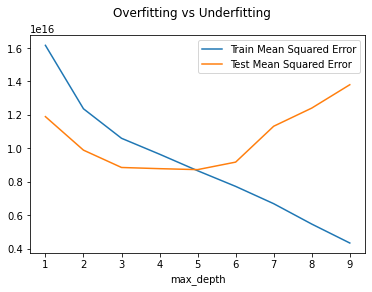

In [17]:
df_mol1["mse_train"].plot(label="Train Mean Squared Error")
df_mol1["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show();

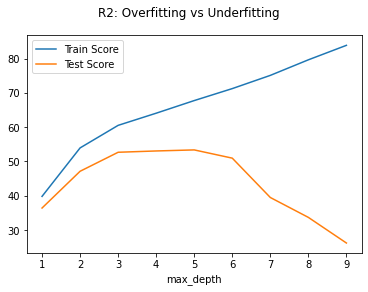

In [18]:
df_mol1["score_train"].plot(label="Train Score")
df_mol1["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

### Entrenamiento y evaluación del modelo

Se probo con 3, 5 y 9 nodos para poder conocer el R2, los resultados son los siguientes; 


|Max_depth|R2|
|-|-|
|3|60%|
|5|67%|
|9|83%|


El modelo sobreajusta, un aumento en la cantidad de nodos genera un aumento nuestro coeficiente de correlación.

In [19]:
"""
------------------------------------------------------------------------------ 
encontramos que el R2 de nuestro primer modelo con 9 nodos es de un 83% lo cual,
me permite entender que mientras aumente la cantidad de nodos mayor ajuste del,
modelo llegando a la conclusión anterior de que existe overfitting.
-------------------------------------------------------------------------------
"""
tree_model = DecisionTreeRegressor(random_state=42, max_depth=9)
tree_model.fit(X_train, y_train)
pred_train = tree_model.predict(X_train)
print (r2_score(y_train, pred_train))

0.8385921784853176


Como los datos  tienen una distribución diferente, es posible que el modelo no funcione bien.

In [20]:
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*tree_model.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*tree_model.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 83.86
Precisión sobre los datos de test: 26.22


### Cálculo de la importancia de las variables

Podemos observar que la variable más importante dentro de nuestro modelo es budget y la que menos influye es country

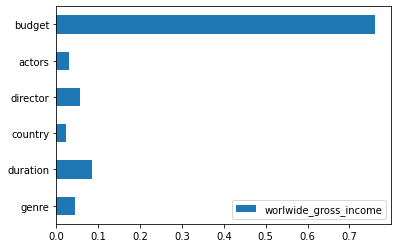

In [21]:
df_imp = pd.DataFrame(tree_model.feature_importances_.reshape(1,-1), columns=X.columns, index=["worlwide_gross_income"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

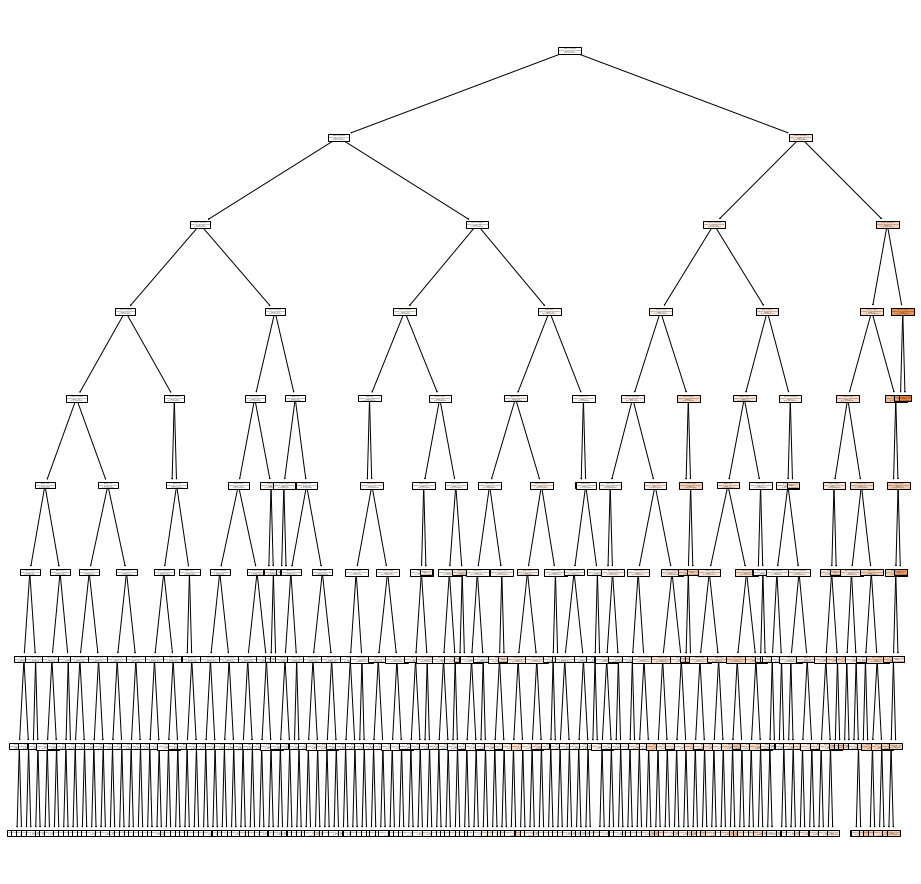

In [23]:
plt.figure(figsize=(16,16))
plot_tree(tree_model, filled=True, max_depth=9, feature_names=X.columns, class_names=["worlwide_gross_income"])
plt.show()

En el presente grafo podemos observar el arbol de decision y sus nodos. El presente grafo presenta incongruencias ya que venimos trabajando con labelencoder()

In [ ]:
# ploteamos decission tree 
dot_data = export_graphviz(tree_model, out_file=None, 
                                feature_names= X.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png")

No entiendo como interpretar que la variable budget se repita varias veces, puede ser producido por el tratamiento de datos. Por consiguiente el siguiente gŕafico no se podría plotear.

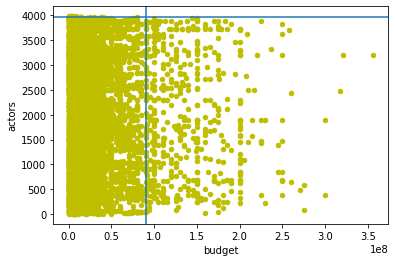

In [26]:
df.plot.scatter(x="budget", y="actors", c="Y", cmap=plt.cm.RdYlBu)
plt.axvline(91000000.0)
plt.axhline(3960.0)

### Predicción 

Las predicciones expresadas en el siguiente modelo nos dan el siguiente resultado, el cual no es el esperado del modelo, el motivo es el tratamiento de los datos. Acá denotamos el impacto del mal pre procesado con labelencoder, por la categorización y la importancia en estos. Los resultados no son los esperados en el modelo.

In [27]:
pred_train = tree_model.predict(X_train[104:107])
pred_train

array([ 4957292.9408284 , 17574010.16666667, 16068536.92892562])

In [28]:
pred_test = tree_model.predict(X_test[104:107])
pred_test

array([57658375.34736842, 44247281.55235205, 63810873.        ])

## Segundo modelo 

### División en train/test

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8664 entries, 0 to 8663
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   8664 non-null   int64  
 1   genre                  8664 non-null   int64  
 2   duration               8664 non-null   int64  
 3   country                8664 non-null   int64  
 4   director               8664 non-null   int64  
 5   actors                 8664 non-null   int64  
 6   avg_vote               8664 non-null   float64
 7   votes                  8664 non-null   int64  
 8   avg_vote_weighted      8664 non-null   float64
 9   budget                 8664 non-null   int64  
 10  worlwide_gross_income  8664 non-null   int64  
 11  reviews_from_users     8664 non-null   int64  
 12  reviews_from_critics   8664 non-null   int64  
dtypes: float64(2), int64(11)
memory usage: 880.1 KB


In [40]:
# Split for the second model to train (variables) genre, duration, country, director, actors, budget, worldwide_gross_income, reviews_from_users y reviews_from_critics.

A = df.iloc[:, [1,2,3,4,5,9,10,11,12]]
b = df.iloc[:, [8]]

In [41]:
# Entrenamos el modelo con los datos, separando el 30% del dataset para el test.

A_train, A_test, b_train, b_test = train_test_split(A.values, b.values,
                                                    random_state=42, test_size=0.3)
print(A_train.shape, b_train.shape)
print(A_test.shape, b_test.shape)


(6064, 9) (6064, 1)
(2600, 9) (2600, 1)


In [49]:
# Encontrar el valor óptimo para maxdepth según la función enseñada en clase.

model2_md_list = []
model2_score_train_list = []
model2_score_test_list = []
model2_mse_train_list = []
model2_mse_test_list = []


for maxdepth in list(range(1,10)):
  tree_model = DecisionTreeRegressor(random_state=42, max_depth=maxdepth)
  tree_model.fit(A_train, b_train)

  pred_train = tree_model.predict(A_train)
  pred_test = tree_model.predict(A_test)

  ## Generación de listas
  model2_md_list.append(maxdepth)
  model2_score_train_list.append(100.0*tree_model.score(A_train, b_train))
  model2_score_test_list.append(100.0*tree_model.score(A_test, b_test))
  model2_mse_train_list.append(mean_squared_error(b_train, pred_train))
  model2_mse_test_list.append(mean_squared_error(b_test, pred_test))

df_mol2 = pd.DataFrame({"max_depth":model2_md_list, 
                   "score_train":model2_score_train_list,
                   "score_test":model2_score_test_list,
                   "mse_train":model2_mse_train_list,
                   "mse_test":model2_mse_test_list
                   })

In [50]:
df_mol2.set_index("max_depth", inplace=True)

1. Cuando analizamos el gráfico de overfitting vs underfitting del MSE podemos observar que las variables actuan distinto al modelo anterior. Por la forma en la cual se dibuja el **test MSE** podemos deducir que el modelo esta balanceado, pero el **train MSE** nos dice que existe un underfitting, es decir el rendimiento del modelo es bajo en los datos de entrenamiento, por eso el aumento con respecto a los nodos. 
 
2. Con respecto análisis del R2, podemos denotar que  con respecto al Train es casi pegado a 0, entonces la correlación no ponderante en el modelo y se detecta underfittinng.

3. El valor óptimo sería 9 nodos de profundidad en el presente modelo, sin embargo podemos ver que el R2 del Test MSE empieza a aumentar cuando llega al 8vo o 9veno codo mientras el Train MSE, disminuye su R2 cuando aumentan los nodos. Recomiendo para este modelo trabajar con 6 nodos.
  


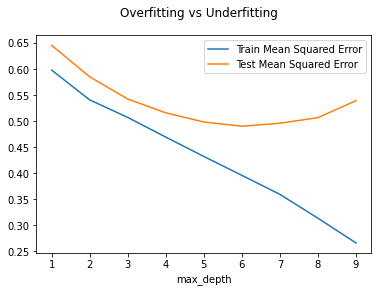

In [51]:
df_mol2["mse_train"].plot(label="Train Mean Squared Error")
df_mol2["mse_test"].plot(label="Test Mean Squared Error")
plt.suptitle("Overfitting vs Underfitting")
plt.legend()
plt.show(); #overfitting 

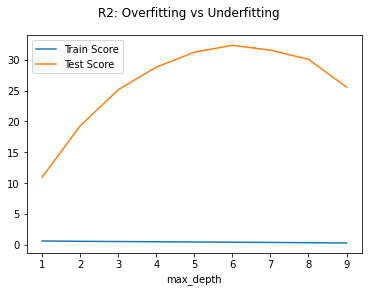

In [53]:
df_mol2["mse_train"].plot(label="Train Score")
df_mol2["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

### Entrenamiento y evaluación del modelo

Se probo con 3, 6 y 9 nodos para poder conocer el R2, los resultados son los siguientes; 


|Max_depth|R2|
|-|-|
|3|26%|
|6|42%|
|9|61%|


No se encuentra un sobreajuste, pero los resultados de correlación  son pobres incluso con 9 nodos, un aumento en la cantidad de nodos genera aumento del r2 pero puede causr un sobreajuste.

In [64]:
tree_model_1 = DecisionTreeRegressor(random_state=42, max_depth=9)
tree_model_1.fit(A_train, b_train)
pred_train = tree_model_1.predict(A_train)
print (r2_score(b_train, pred_train))

0.6159358643898388


La precisión del modelo es ineficiente para generar una predicción

In [55]:
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*tree_model_1.score(A_train, b_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*tree_model_1.score(A_test, b_test)))

Precisión sobre los datos de entrenamiento: 61.59
Precisión sobre los datos de test: 25.58


### Cálculo de la importancia de las variables

Podemos observar que la variable más importante dentro de nuestro modelo es reviews_from_users y la que menos influye es country

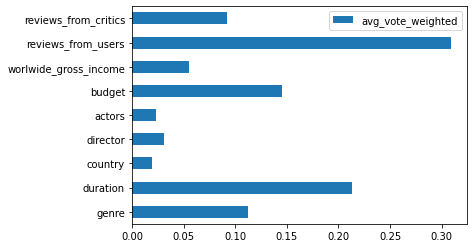

In [56]:
df_imp = pd.DataFrame(tree_model_1.feature_importances_.reshape(1,-1), columns=A.columns, index=["avg_vote_weighted"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

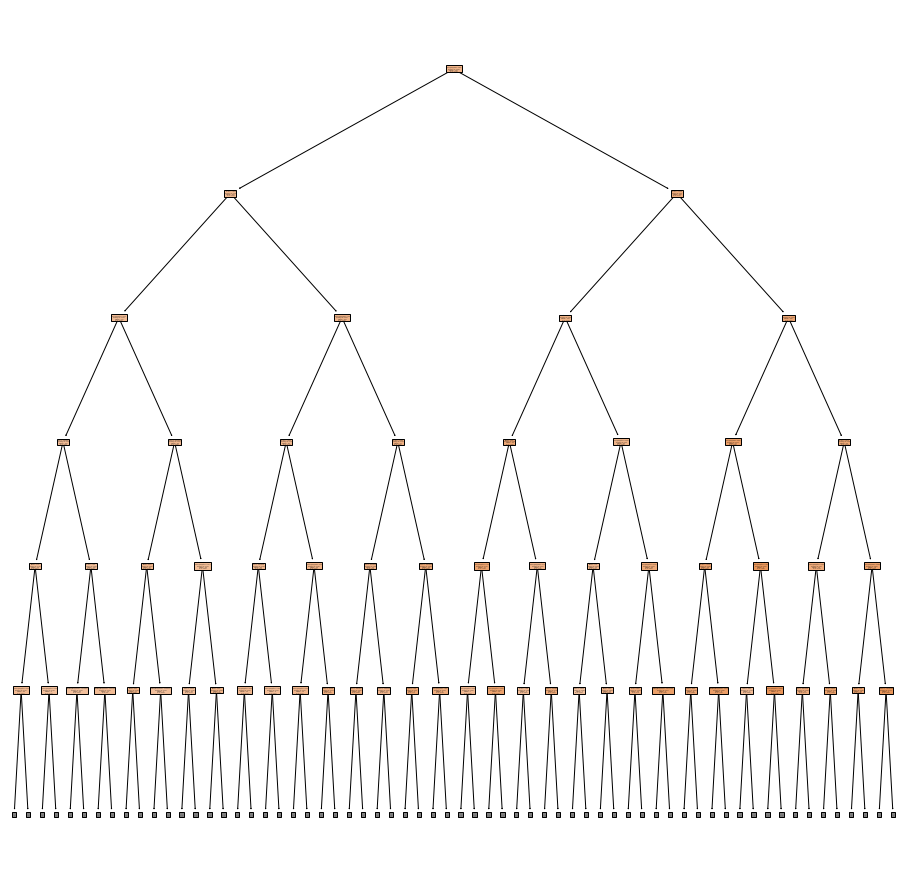

In [57]:
plt.figure(figsize=(16,16))
plot_tree(tree_model_1, filled=True, max_depth=5, feature_names=A.columns, class_names=["avg_vote_weighted"])
plt.show()

In [ ]:
# ploteamos decission tree 
dot_data = export_graphviz(tree_model_1, out_file=None, 
                                feature_names= A.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png")

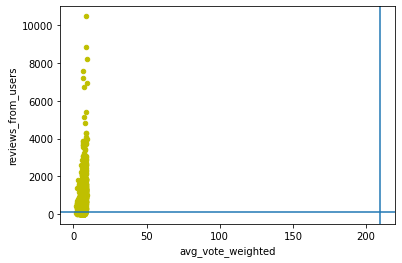

In [60]:
df.plot.scatter(x="avg_vote_weighted", y="reviews_from_users", c="Y", cmap=plt.cm.RdYlBu)
plt.axvline(209.5)
plt.axhline(104.5)

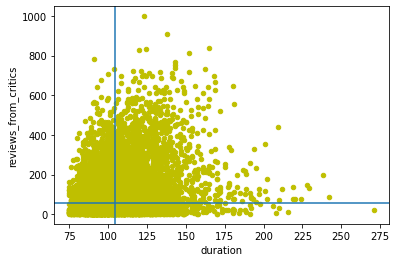

In [61]:
df.plot.scatter(x="duration", y="reviews_from_critics", c="Y", cmap=plt.cm.RdYlBu)
plt.axvline(104.5)
plt.axhline(54.4)

### Predicción 

Las predicciones expresadas en el siguiente modelo nos dan el siguiente resultado, el cual no es el esperado del modelo, el motivo es el tratamiento de los datos. Acá denotamos el impacto del mal pre procesado con labelencoder, por la categorización y la importancia en estos. Los resultados no son los esperados en el modelo.

In [90]:
pred_train_1 = tree_model_1.predict(A_train[104:107])
pred_train_1

array([6.28722222, 7.53837838, 4.10333333])

In [98]:
pred_test_1 = tree_model_1.predict(A_test[104:107])
pred_test_1

array([6.60064516, 6.07971429, 6.00466667])

# Conclusiones.

1. Al incluso haber trabajado el dataset de una manera distinta, podemos denotar como actuan los datos cuando existe overfitting o underfitting y la relación que tienen con la precisión del modelo y su R2, si bien es cierto que un aumento de nodos en nuestro arboles de decisiones genera un aumento en el R2 corremos el riesgo de sobre ajustar el modelo y cometer errores de predicción. 

2. En el primer modelo se genero un error, ya que el nodo repartia a maś nodos con respecto a BUDGET, por lo cual cuando uno queiere plotear las relaciones entre dos variables no se puede denotar.

3. He observado como impacta la categorización alfabetica en los datos cuando no se debe aplicar a un modelo. Este aprendizaje me confirma lo clave que es el pre análisis de los datos y su categorización eficiente. 